In [1]:
import os
import random
import pandas as pd
import shutil
!pip install torchsummary pytorch-ignite
from torchsummary import summary
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import ignite.contrib.engines.common as common

# Question 1


In [3]:
#load the data into a dataframe
data_val=pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt',sep='\t',header=None)

In [4]:
headers=['filename','label','2','3','4','5']
data_val.columns=headers
data_val

,filename,label,2,3,4,5
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48
...,...,...,...,...,...,...
9995,val_9995.JPEG,n03085013,0,0,63,63
9996,val_9996.JPEG,n03444034,0,9,63,63
9997,val_9997.JPEG,n03424325,10,10,38,42
9998,val_9998.JPEG,n01629819,28,18,63,31


In [5]:
#selecting 10 random classes from the train folder and storing the labels in a list
train_labels_list=[]
i=0
if not os.path.isdir('./tiny-imagenet-200/train_10'):
    os.mkdir("./tiny-imagenet-200/validation_10/")
    os.mkdir("./tiny-imagenet-200/train_10/")
    while i<10:
        x=random.choice(os.listdir("./tiny-imagenet-200/train/"))
        if(x in train_labels_list):
            i=i-1
        else:
            train_labels_list.append(x)
        i=i+1
train_labels_list

['n03201208',
 'n04596742',
 'n04532670',
 'n03255030',
 'n04399382',
 'n02281406',
 'n02480495',
 'n09332890',
 'n04376876',
 'n04070727']

In [6]:
#select the same labeled folders from val folder as well
data_val = data_val[data_val['label'].isin(train_labels_list)]
data_val['label'].unique()

array(['n04070727', 'n04399382', 'n04532670', 'n04376876', 'n04596742',
       'n03201208', 'n02480495', 'n02281406', 'n09332890', 'n03255030'],
      dtype=object)

In [7]:
data_val

,filename,label,2,3,4,5
2,val_2.JPEG,n04070727,4,0,60,55
5,val_5.JPEG,n04399382,7,0,59,63
24,val_24.JPEG,n04532670,0,19,63,31
46,val_46.JPEG,n04376876,5,9,63,23
85,val_85.JPEG,n04399382,1,3,63,63
...,...,...,...,...,...,...
9826,val_9826.JPEG,n04532670,0,16,63,33
9859,val_9859.JPEG,n04070727,20,1,63,63
9877,val_9877.JPEG,n02480495,2,18,63,57
9879,val_9879.JPEG,n02480495,0,0,63,63


In [8]:
#make folders for the selected labels and put the images in a new folder validation_10
for i in train_labels_list:
    path = os.path.join("./tiny-imagenet-200/validation_10/", i)
    os.mkdir(path) 

In [9]:
for index, row in data_val.iterrows():
    src = os.path.join("./tiny-imagenet-200/val/images/", row['filename'])
    dst = os.path.join("./tiny-imagenet-200/validation_10/", row['label'])
    shutil.copy(src, dst)

In [10]:
for i in train_labels_list:
    src = os.path.join("./tiny-imagenet-200/train/", i)
    dst = os.path.join("./tiny-imagenet-200/train_10/", i)
    shutil.copytree(src, dst) 

In [11]:
from torchvision import datasets

def make_dl(data, name, transform):
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}

    dl = DataLoader(dataset, batch_size=32, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dl

In [12]:
transorms = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

train_loader = make_dl("./tiny-imagenet-200/train_10/", "train_10",
                                  transform=transorms)

val_loader = make_dl("./tiny-imagenet-200/validation_10/", "val_10",
                                 transform=transorms)

## AlexNet

In [13]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
AlexNet_model.classifier[4] = nn.Linear(4096,1024)
AlexNet_model.classifier[6] = nn.Linear(1024,10)

Using cache found in /home/sid/.cache/torch/hub/pytorch_vision_v0.6.0


In [14]:
AlexNet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
lr = 0.001                # Learning rate
num_epochs = 10           # Number of epochs
log_interval = 300        # Number of iterations before logging

loss_func = nn.CrossEntropyLoss()

optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)   #SGD optimizer

In [16]:
trainer = create_supervised_trainer(AlexNet_model, optimizer, loss_func, device=device)
ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"Batch Loss": x})

In [17]:
#model summary
summary(AlexNet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

Number of parameters = 44,428,106

In [18]:
# evaluation metrics
metrics = {
    "accuracy": Accuracy(), 
    "loss": Loss(loss_func),
}

In [19]:
# Evaluator for training data
train_val = create_supervised_evaluator(AlexNet_model, metrics=metrics, device=device)

# Evaluator for validation data
test_val = create_supervised_evaluator(AlexNet_model, metrics=metrics, device=device)

In [20]:
train_error=[]
test_error=[]
train_accuracy=[]
test_accuracy=[]
@trainer.on(Events.STARTED)
def begin():
    print("training started.....")

@trainer.on(Events.EPOCH_COMPLETED)
def train_stat(trainer):
    print(f"Epoch - {trainer.state.epoch} and Loss - {trainer.state.output}")
    train_val.run(train_loader)
    epoch = trainer.state.epoch
    print(f"Train error - {train_val.state.metrics['loss']}")
    print(f"Train accuracy - {train_val.state.metrics['accuracy']}")
    train_error.append(train_val.state.metrics['loss'])
    train_accuracy.append(train_val.state.metrics['accuracy'])


@trainer.on(Events.EPOCH_COMPLETED)
def test_stat(trainer):
    test_val.run(val_loader)
    epoch = trainer.state.epoch
    print(f"test error - {test_val.state.metrics['loss']}")
    print(f"test accuracy - {test_val.state.metrics['accuracy']}")
    test_error.append(test_val.state.metrics['loss'])
    test_accuracy.append(test_val.state.metrics['accuracy'])

In [21]:
trainer.run(train_loader, max_epochs=num_epochs)

training started.....


[1/157]   1%|           [00:00<?]

Epoch - 1 and Loss - 2.3459689617156982
Train error - 2.302578125
Train accuracy - 0.1
test error - 2.302557861328125
test accuracy - 0.1


[1/157]   1%|           [00:00<?]

Epoch - 2 and Loss - 2.3266286849975586
Train error - 2.3024759765625
Train accuracy - 0.106
test error - 2.30246533203125
test accuracy - 0.104


[1/157]   1%|           [00:00<?]

Epoch - 3 and Loss - 2.3139266967773438
Train error - 2.3024572265625
Train accuracy - 0.1
test error - 2.302450439453125
test accuracy - 0.1


[1/157]   1%|           [00:00<?]

Epoch - 4 and Loss - 2.303494453430176
Train error - 2.30247421875
Train accuracy - 0.1
test error - 2.302457763671875
test accuracy - 0.1


[1/157]   1%|           [00:00<?]

Epoch - 5 and Loss - 2.2954204082489014
Train error - 2.3025005859375
Train accuracy - 0.1008
test error - 2.30249462890625
test accuracy - 0.1


[1/157]   1%|           [00:00<?]

Epoch - 6 and Loss - 2.286898136138916
Train error - 2.302538671875
Train accuracy - 0.1162
test error - 2.30251904296875
test accuracy - 0.126


[1/157]   1%|           [00:00<?]

Epoch - 7 and Loss - 2.282398223876953
Train error - 2.302562109375
Train accuracy - 0.151
test error - 2.302538330078125
test accuracy - 0.164


[1/157]   1%|           [00:00<?]

Epoch - 8 and Loss - 2.2773561477661133
Train error - 2.3025783203125
Train accuracy - 0.1614
test error - 2.302543701171875
test accuracy - 0.166


[1/157]   1%|           [00:00<?]

Epoch - 9 and Loss - 2.2738189697265625
Train error - 2.3025728515625
Train accuracy - 0.1372
test error - 2.302530029296875
test accuracy - 0.148


[1/157]   1%|           [00:00<?]

Epoch - 10 and Loss - 2.270381450653076
Train error - 2.3025208984375
Train accuracy - 0.1276
test error - 2.302468505859375
test accuracy - 0.142


State:
	iteration: 1570
	epoch: 10
	epoch_length: 157
	max_epochs: 10
	output: 2.270381450653076
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

#### Accuracy and loss of AlexNet

In [22]:
print(test_val.state.metrics)

{'accuracy': 0.142, 'loss': 2.302468505859375}


#### Accuracy and error plots

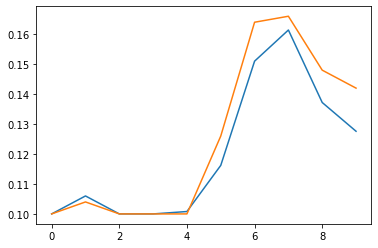

In [23]:
plt.plot(train_accuracy)
plt.plot(test_accuracy)

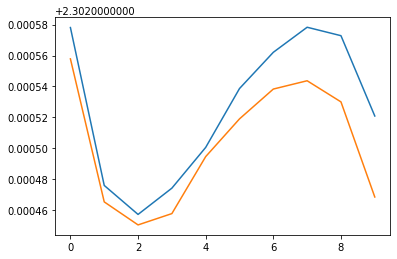

In [24]:
plt.plot(train_error)
plt.plot(test_error)

## RESNET50

In [25]:
import torchvision.models as models
ResNet50_model =models.resnet50(pretrained=False)

In [26]:
ResNet50_model = ResNet50_model.cuda() if device else ResNet50_model

In [27]:
num_ftrs = ResNet50_model.fc.in_features
ResNet50_model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 10)).to(device)
ResNet50_model.fc = ResNet50_model.fc.cuda() if use_cuda else ResNet50_model.fc

In [28]:
trainer = create_supervised_trainer(ResNet50_model, optimizer, loss_func, device=device)
ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"Batch Loss": x})


In [29]:
train_val = create_supervised_evaluator(ResNet50_model, metrics=metrics, device=device)
test_val = create_supervised_evaluator(ResNet50_model, metrics=metrics, device=device)

In [30]:
train_error=[]
test_error=[]
train_accuracy=[]
test_accuracy=[]

@trainer.on(Events.STARTED)
def begin():
    print("training started.....")

@trainer.on(Events.EPOCH_COMPLETED)
def train_stat(trainer):
    print(f"Epoch - {trainer.state.epoch} and Loss - {trainer.state.output}")
    train_val.run(train_loader)
    epoch = trainer.state.epoch
    print(f"Train error - {train_val.state.metrics['loss']}")
    print(f"Train accuracy - {train_val.state.metrics['accuracy']}")
    train_error.append(train_val.state.metrics['loss'])
    train_accuracy.append(train_val.state.metrics['accuracy'])

# Evaluate and print validation set metrics
@trainer.on(Events.EPOCH_COMPLETED)
def test_stat(trainer):
    test_val.run(val_loader)
    epoch = trainer.state.epoch
    print(f"test error - {test_val.state.metrics['loss']}")
    print(f"test accuracy - {test_val.state.metrics['accuracy']}")
    test_error.append(test_val.state.metrics['loss'])
    test_accuracy.append(test_val.state.metrics['accuracy'])

In [31]:
summary(ResNet50_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Number of parameters = 44,428,106

In [32]:
# Start training
trainer.run(train_loader, max_epochs=5)

training started.....


[1/157]   1%|           [00:00<?]

Epoch - 1 and Loss - 2.4946014881134033
Train error - 2.3342271484375
Train accuracy - 0.0974
test error - 2.329771728515625
test accuracy - 0.098


[1/157]   1%|           [00:00<?]

Epoch - 2 and Loss - 2.4940717220306396
Train error - 2.335139453125
Train accuracy - 0.0972
test error - 2.329457275390625
test accuracy - 0.088


[1/157]   1%|           [00:00<?]

Epoch - 3 and Loss - 2.4893014430999756
Train error - 2.3329740234375
Train accuracy - 0.0954
test error - 2.328405517578125
test accuracy - 0.094


[1/157]   1%|           [00:00<?]

Epoch - 4 and Loss - 2.4926133155822754
Train error - 2.3351970703125
Train accuracy - 0.0978
test error - 2.3275546875
test accuracy - 0.096


[1/157]   1%|           [00:00<?]

Epoch - 5 and Loss - 2.4900317192077637
Train error - 2.334038671875
Train accuracy - 0.099
test error - 2.330614501953125
test accuracy - 0.092


State:
	iteration: 785
	epoch: 5
	epoch_length: 157
	max_epochs: 5
	output: 2.4900317192077637
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [33]:
print(test_val.state.metrics)

{'accuracy': 0.092, 'loss': 2.330614501953125}


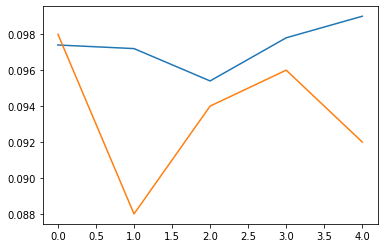

In [34]:
plt.plot(train_accuracy)
plt.plot(test_accuracy)

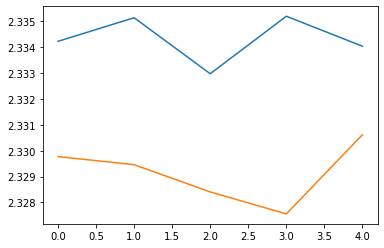

In [35]:
plt.plot(train_error)
plt.plot(test_error)

### Comaprision of both the models

As we can see , the accuracy of AlexNet is more than that of ResNet50.
For the training loss to stabilize, ResNet50 takes longer time compared to ResNet - The number of epochs in ResNet50 is more than that of AlexNet and also the time tak

# Question 2

In [36]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Slusarski


In [37]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor



In [38]:
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size) #gru cell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)
    
    def forward(self, input_, hidden):
        out, hidden = self.gru_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)

In [39]:
input = letterToTensor('A')
hidden = torch.zeros(1, 1, n_hidden)

output, next_hidden = gru(input, hidden)

In [40]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, 1, n_hidden)

output, next_hidden = gru(input[0], hidden)

In [41]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [42]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Brahms
category = Dutch / line = Meeuweszen
category = Japanese / line = Hamacho
category = Scottish / line = Lindsay
category = Arabic / line = Wasem
category = Scottish / line = Morrison
category = Korean / line = Lee
category = Czech / line = Konarik
category = Dutch / line = Kolen
category = Irish / line = O'Rourke


In [43]:
criterion = nn.NLLLoss()

In [44]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = gru.initHidden()

    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()

    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [45]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.8256 Albert / French ✗ (Spanish)
10000 10% (0m 23s) 2.6711 Shum / Chinese ✓
15000 15% (0m 35s) 2.6209 Sierra / Japanese ✗ (Spanish)
20000 20% (0m 47s) 1.9239 Tomanek / Czech ✓
25000 25% (0m 59s) 3.2063 Amatore / French ✗ (Italian)
30000 30% (1m 11s) 2.1935 Janca / Spanish ✗ (Czech)
35000 35% (1m 22s) 1.0724 Yuan / Vietnamese ✗ (Chinese)
40000 40% (1m 34s) 3.4815 Douthwaite / Japanese ✗ (English)
45000 45% (1m 46s) 1.4928 D'cruz / Spanish ✗ (Portuguese)
50000 50% (1m 58s) 2.9359 Adam / Arabic ✗ (Irish)
55000 55% (2m 9s) 0.7811 Orellana / Spanish ✓
60000 60% (2m 21s) 1.6929 Hafernik / Russian ✗ (Czech)
65000 65% (2m 33s) 0.4805 Hideaki / Japanese ✓
70000 70% (2m 45s) 0.8069 Lobo / Portuguese ✓
75000 75% (2m 57s) 3.2820 Kalbfleisch / Czech ✗ (German)
80000 80% (3m 9s) 2.0678 Campbell / Dutch ✗ (Scottish)
85000 85% (3m 20s) 2.4592 O'Shea / Japanese ✗ (Irish)
90000 90% (3m 32s) 1.3425 Nicastro / Spanish ✗ (Italian)
95000 95% (3m 44s) 1.3402 Garber / German ✓
100000 100% (

### Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




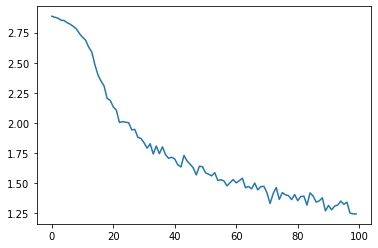

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_3033/2129871859.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_3033/2129871859.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


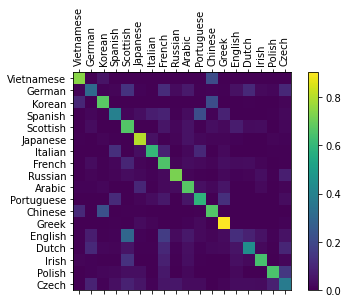

In [47]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = gru.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

# LSTM

In [48]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size) #LSTM cell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)

    def forward(self, input_, hidden):
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output.view(1, -1), hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

In [49]:
learning_rate = 0.0005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = lstm.initHidden()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [50]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 12s) 2.8474 Torii / Spanish ✗ (Japanese)
10000 10% (0m 25s) 2.8435 Saifulin / Portuguese ✗ (Russian)
15000 15% (0m 37s) 2.8670 Rodriguez / Vietnamese ✗ (Spanish)
20000 20% (0m 50s) 2.8468 Rocha / Portuguese ✓
25000 25% (1m 3s) 2.8713 Johnston / Portuguese ✗ (Scottish)
30000 30% (1m 15s) 2.8866 Kalb / Portuguese ✗ (Arabic)
35000 35% (1m 28s) 2.8749 Seghers / Portuguese ✗ (Dutch)
40000 40% (1m 41s) 2.9156 Jiang / German ✗ (Chinese)
45000 45% (1m 53s) 2.8460 Bruhn / German ✓
50000 50% (2m 6s) 2.8811 Sook / Portuguese ✗ (Korean)
55000 55% (2m 19s) 2.8668 Grant / English ✗ (Scottish)
60000 60% (2m 31s) 2.9479 Jelen / English ✗ (Polish)
65000 65% (2m 44s) 2.8705 Lennon / English ✗ (Irish)
70000 70% (2m 56s) 2.8719 Maslanka / Japanese ✗ (Polish)
75000 75% (3m 9s) 2.9157 Kwan / Japanese ✗ (Chinese)
80000 80% (3m 22s) 2.8423 Meeuweszen / Dutch ✓
85000 85% (3m 34s) 2.8795 Husk / Polish ✗ (Czech)
90000 90% (3m 47s) 2.9326 She / Dutch ✗ (Chinese)
95000 95% (4m 0s) 2.8924 Comtois / Gree

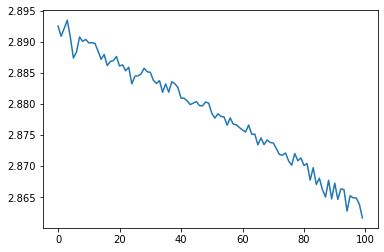

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_3033/4175093726.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_3033/4175093726.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


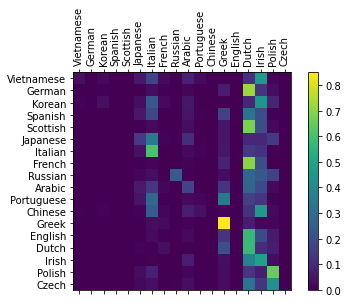

In [52]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()